In [1]:
import os
import logging
import time
import numpy as np
import h5py
import matplotlib.pyplot as plt
from scipy.sparse.linalg import eigsh
import numpy as np
import h5py
import jax
import jax.numpy as jnp
from jax.experimental.sparse import BCOO
from qiskit.circuit import Parameter
from qiskit_aer import AerSimulator
from qiskit_addon_sqd.qubit import solve_qubit
from heavyhex_qft.triangular_z2 import TriangularZ2Lattice
from heavyhex_qft.plaquette_dual import PlaquetteDual
from skqd_z2lgt.circuits import make_plaquette_circuits, compose_trotter_circuits
from skqd_z2lgt.ising_dmrg import ising_dmrg, get_mps_probs
from skqd_z2lgt.sqd import keys_to_intset, ground_state_lobpcg

logging.basicConfig(level=logging.WARNING)
#logging.getLogger('skqd').setLevel(logging.INFO)

os.environ['PATH'] = '/opt/julia/iiyama/julia/bin:' + os.environ['PATH']
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '0.99'
os.environ['CUDA_VISIBLE_DEVICES'] = '0' #,1,2,3,4,5,6,7'
jax.config.update('jax_enable_x64', True)

data_dir = '/data/iiyama/2dz2'

In [2]:
from qiskit_ibm_runtime import QiskitRuntimeService
service = QiskitRuntimeService(instance='ICEPP-dedicated-temp-prem-us')
backend = service.backend('ibm_pittsburgh')

In [3]:
# 30 qubits
# lattice = TriangularZ2Lattice('''
#  * * * *
# * * * *
#  * * * *
# * * * *
#  * * * *
# * * * *
# ''')
# 24 qubits
lattice = TriangularZ2Lattice('''
 * * * *
* * * *
 * * * *
* * * *
 * * * *
''')
# lattice = TriangularZ2Lattice('''
#   ^ ^ ^
#  * * * *
# * * * * *
#  * * * *
# * * * * *
#  * * * *
# * * * * *
#  * * * *
#   v v v
# ''')
plaquette_energy = 0.7
max_steps = 8
shots = 100000
num_experiments = 1

dual_lattice = PlaquetteDual(lattice)
hamiltonian = dual_lattice.make_hamiltonian(plaquette_energy)
num_plaq = hamiltonian.num_qubits
print(num_plaq)

24


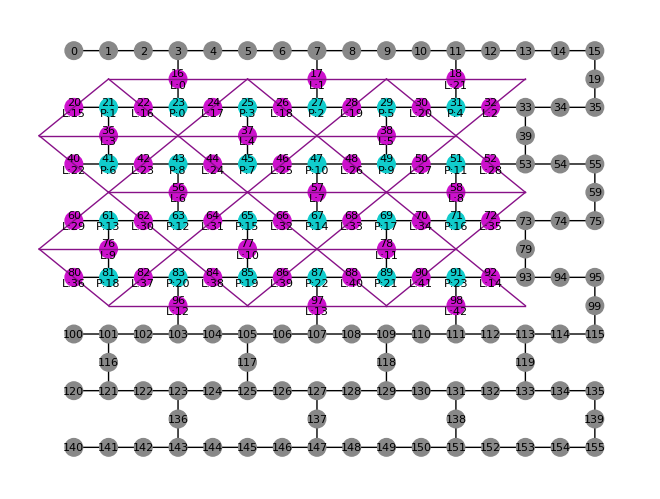

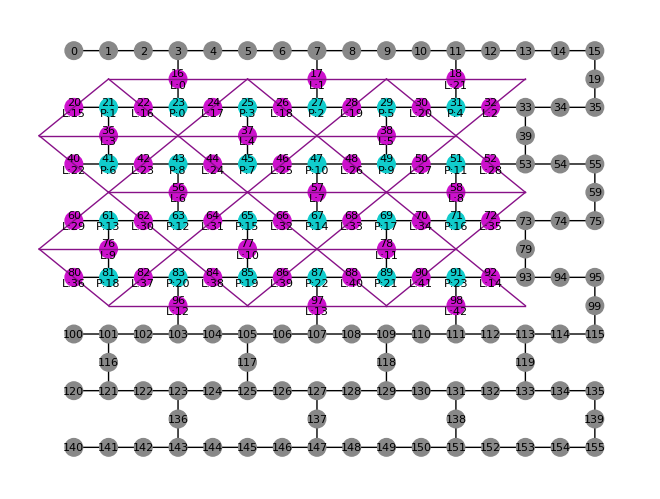

In [4]:
layout = lattice.layout_heavy_hex(backend.coupling_map, qubit_assignment=16, backend_properties=backend.properties(), basis_2q='cz')
lattice.draw_qubit_graph(layout, backend.coupling_map)

In [5]:
filename = f'{data_dir}/dmrg/{num_plaq}plaq_k{plaquette_energy:.2f}.h5'
if os.path.exists(filename):
    with h5py.File(filename, 'r') as source:
        lattice_conf = source['lattice_conf'][()].decode()
        dmrg_energy = source['energy'][()]

    if lattice_conf.strip() != lattice.configuration.strip():
        raise RuntimeError('Incompatible data file')
else:
    dmrg_energy = ising_dmrg(hamiltonian, filename=filename)
    with h5py.File(filename, 'r+') as out:
        out.create_dataset('lattice_conf', data=lattice.configuration)
        out.create_dataset('plaquette_energy', data=plaquette_energy)


In [6]:
eigh_energy = None
eigsh_energy = None
if num_plaq < 12:
    evals, evecs = jnp.linalg.eigh(hamiltonian.to_matrix())
    eigh_energy = evals[0]

if num_plaq < 20:
    eigsh_energy, _ = ground_state_lobpcg(BCOO.from_scipy_sparse(hamiltonian.to_matrix(sparse=True)))
elif num_plaq < 26:
    evals, evecs = eigsh(hamiltonian.to_matrix(sparse=True), k=1, which='SA')
    eigsh_energy = evals[0]

In [7]:
dmrg_energy, eigh_energy, eigsh_energy

(np.float64(-44.965451537637584), None, np.float64(-44.96545163712208))

In [8]:
if num_plaq < 35:
    dtvals = np.linspace(0.1, 0.6, 6)
    samples = np.empty((dtvals.shape[0], max_steps, num_experiments), dtype=object)

    filename = f'{data_dir}/plaqsim_data/'
    filename += f'{hamiltonian.num_qubits}plaqs_k{plaquette_energy:.2f}_{max_steps}steps_{shots}shots.h5'

    if os.path.exists(filename):
        with h5py.File(filename, 'r') as source:
            proj_energies = source['proj_energies'][()]
            for idt, dtval in enumerate(dtvals):
                for istep in range(max_steps):
                    for iexp in range(num_experiments):
                        samples[idt, istep, iexp] = source[f'dt{idt}_step{istep + 1}_exp{iexp}'][()]

    else:
        delta_t = Parameter(r'$\Delta t$')
        step_circuits = make_plaquette_circuits(dual_lattice, plaquette_energy, delta_t)
        trotter_step = step_circuits[0]
        measure = step_circuits[-1]

        simulator = AerSimulator(method='statevector', device='GPU', max_parallel_experiments=0,
                                num_threads_per_device=16)

        for idt, dtval in enumerate(dtvals):
            print('dt', dtval)
            step_circ = trotter_step.assign_parameters({delta_t: dtval}, inplace=False)
            circuits = compose_trotter_circuits(step_circ, measure, max_steps)

            result = simulator.run(circuits * num_experiments, shots=shots).result()
            print('sim completed')
            for iexp in range(num_experiments):
                keys = result.get_counts(max_steps * iexp).keys()
                samples[idt, 0, iexp] = keys_to_intset(keys)
                print(len(samples[idt, 0, iexp]), 'samples at step 0')
                for istep in range(1, max_steps):
                    keys = result.get_counts(max_steps * iexp + istep).keys()
                    samples[idt, istep, iexp] = samples[idt, istep - 1, iexp] | keys_to_intset(keys)
                    print(len(samples[idt, istep, iexp]), 'samples at step', istep)

        proj_energies = np.empty_like(samples, dtype=float)
        for idt in range(dtvals.shape[0]):
            print('dt', idt)
            for istep in range(max_steps):
                print('step', istep)
                for iexp in range(num_experiments):
                    print('exp', iexp)
                    smp = np.array(list(samples[idt, istep, iexp]))
                    samples[idt, istep, iexp] = smp
                    bitstring_matrix = ((smp[:, None] >> np.arange(num_plaq)[None, ::-1]) % 2).astype(bool)
                    start = time.time()
                    evals, evecs = solve_qubit(bitstring_matrix, hamiltonian)
                    end = time.time()
                    print(f'Used {end - start} seconds for subspace diagonalization')
                    proj_energies[idt, istep, iexp] = evals[0]

        with h5py.File(filename, 'w') as out:
            out.create_dataset('dtvals', data=dtvals)
            out.create_dataset('proj_energies', data=proj_energies)
            for idt, dtval in enumerate(dtvals):
                for istep in range(max_steps):
                    for iexp in range(num_experiments):
                        out.create_dataset(f'dt{idt}_step{istep + 1}_exp{iexp}',
                                           data=samples[idt, istep, iexp])

else:
    # Cannot run a circuit simulation in a reasonable time - compute the sample probs from MPS
    filename = f'{data_dir}/plaqsim_data/'
    filename += f'{hamiltonian.num_qubits}plaqs_k{plaquette_energy:.2f}_mps_{shots}shots.h5'
    samples = np.empty(num_experiments, dtype=object)
    probs = np.empty(num_experiments, dtype=object)
    if os.path.exists(filename):
        with h5py.File(filename, 'r') as source:
            proj_energies = source['proj_energies'][()]
            for iexp in range(num_experiments):
                samples[iexp] = source[f'samples_exp{iexp}'][()]
                probs[iexp] = source[f'probs_exp{iexp}'][()]

    else:
        proj_energies = np.empty(num_experiments)
        mps_filename = f'{data_dir}/dmrg/{num_plaq}plaq_k{plaquette_energy:.2f}.h5'
        for iexp in range(num_experiments):
            with h5py.File(mps_filename, 'r+') as source:
                for key in ['states', 'probs']:
                    try:
                        del source[key]
                    except:
                        pass

            samples[iexp], probs[iexp] = get_mps_probs(mps_filename, num_samples=shots)
            bitstring_matrix = samples[:, ::-1].astype(bool)
            print('solve_qubit over', bitstring_matrix.shape[0], 'samples')
            evals, evecs = solve_qubit(bitstring_matrix, hamiltonian, k=1, which='SA')
            proj_energies[iexp] = evals[0]

        with h5py.File(filename, 'w') as out:
            out.create_dataset('proj_energies', data=proj_energies)
            for iexp in range(num_experiments):
                out.create_dataset(f'samples_exp{iexp}', data=samples[iexp])
                out.create_dataset(f'probs_exp{iexp}', data=probs[iexp])

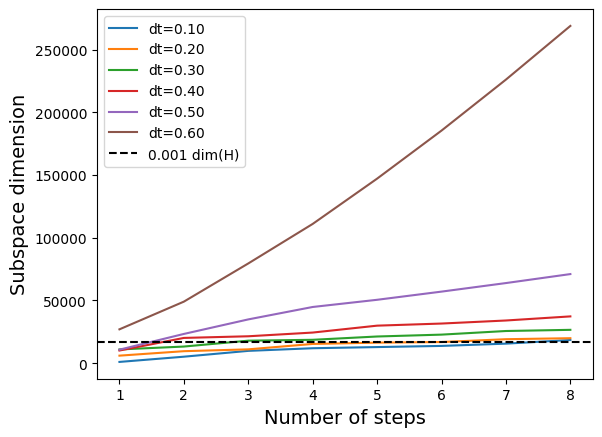

In [9]:
if num_plaq < 35:
    proj_dimensions = np.array([
        [
            [len(samples[idt, istep, iexp]) for iexp in range(num_experiments)]
            for istep in range(max_steps)
        ]
        for idt in range(dtvals.shape[0])
    ])

    x = np.arange(1, max_steps + 1)
    for idt, dtval in enumerate(dtvals):
        plt.plot(x, np.mean(proj_dimensions[idt], axis=1), label=f'dt={dtval:.2f}')
    plt.axhline(2 ** num_plaq * 0.001, color='black', linestyle='--', label='0.001 dim(H)')
    plt.xlabel('Number of steps', fontsize=14)
    plt.ylabel('Subspace dimension', fontsize=14)
    plt.legend();

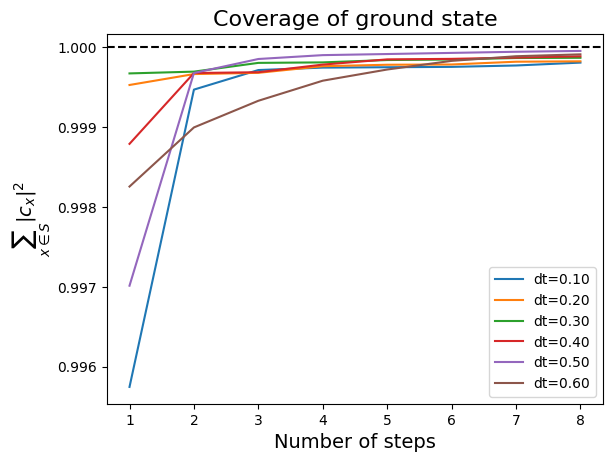

In [10]:
if num_plaq < 35:
    coverages = np.array([
        [
            [np.sum(np.square(np.abs(evecs[samples[idt, istep, iexp], 0]))) for iexp in range(num_experiments)]
            for istep in range(max_steps)
        ]
        for idt in range(dtvals.shape[0])
    ])

    for idt, dtval in enumerate(dtvals):
        plt.plot(x, np.mean(coverages[idt], axis=1), label=f'dt={dtval:.2f}')
    plt.axhline(1.0, color='black', linestyle='--')
    plt.xlabel('Number of steps', fontsize=14)
    plt.ylabel(r'$\sum_{x \in S} |c_x|^2$', fontsize=14)
    plt.title('Coverage of ground state', fontsize=16)
    plt.legend();

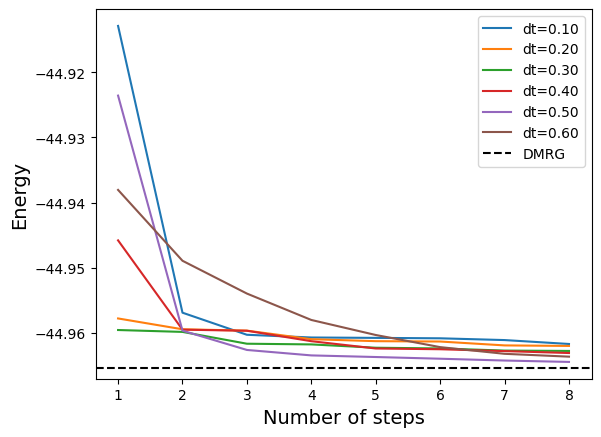

In [11]:
if num_plaq < 35:
    for idt, dtval in enumerate(dtvals):
        plt.plot(x, np.mean(proj_energies[idt], axis=1), label=f'dt={dtval:.2f}')
    plt.axhline(dmrg_energy, color='black', linestyle='--', label='DMRG')
    plt.xlabel('Number of steps', fontsize=14)
    plt.ylabel('Energy', fontsize=14)
    plt.legend();